In [1]:
# import the libraries for the visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# import the libraries to perform the regression model
from scipy.stats import chi2_contingency
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import make_pipeline

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# load the dataset
dataset = pd.read_csv('data/sport_dataset.csv')

In [3]:
dataset.head()

,Unnamed: 0,type of activity,location,company,degree,department,neighborhood,sex
0,0,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
1,1,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
2,2,Outdoor activities,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
3,3,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
4,4,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female


In [4]:
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset.head()

,type of activity,location,company,degree,department,neighborhood,sex
0,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
1,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
2,Outdoor activities,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
3,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female
4,Walking,outdoor,company,MSc,Engineering and Applied Sciences,Trento South (Bolghera/Clarina/San Bartolomeo/...,Female


# Pre-processing & data cleaning
all the nan values have already been dropped in the data cleaning process of the previous steps (see Processing_and_cleaning_data.ipynb)

In [5]:
dataset.shape

(623, 7)

# Explanatory Data Analysis on the dataset

## Univariate analysis
From displaying the distribution of the variable we notice that many have unbalanced classes, which is not that good unfortunately.

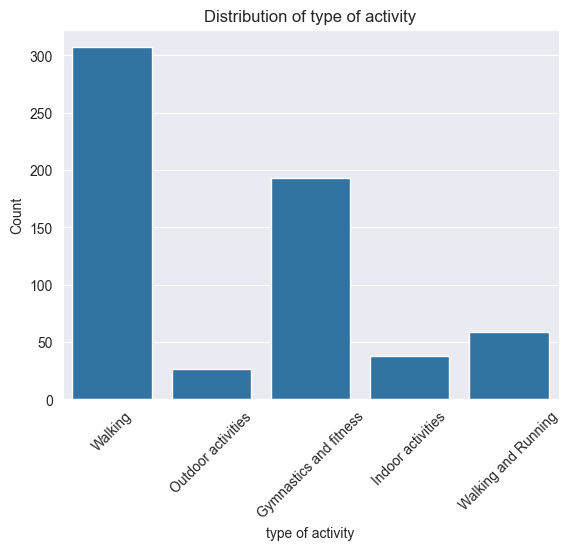

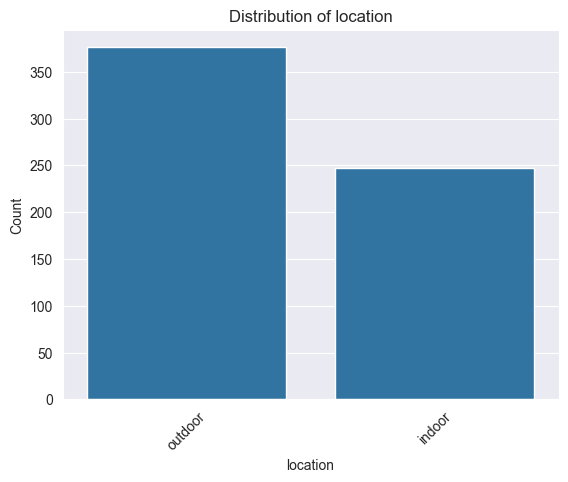

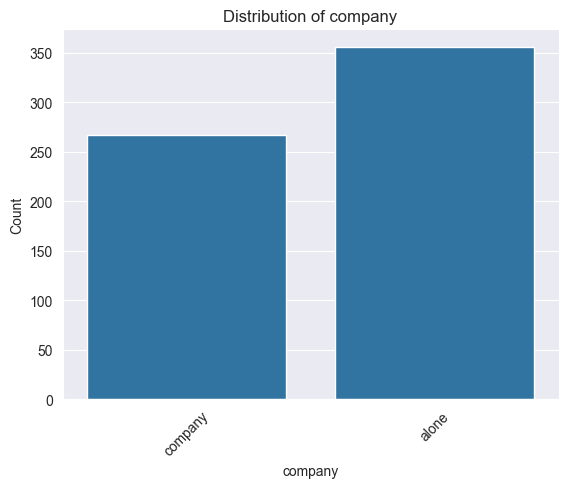

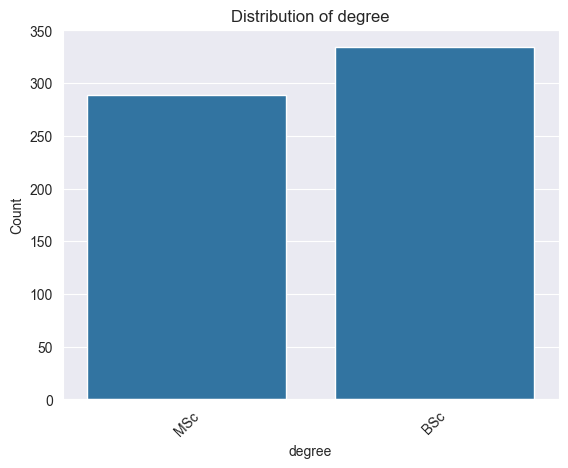

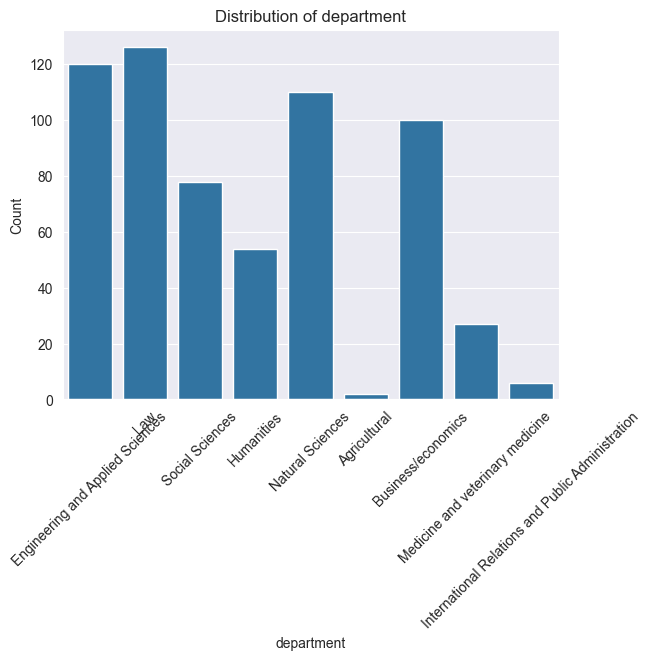

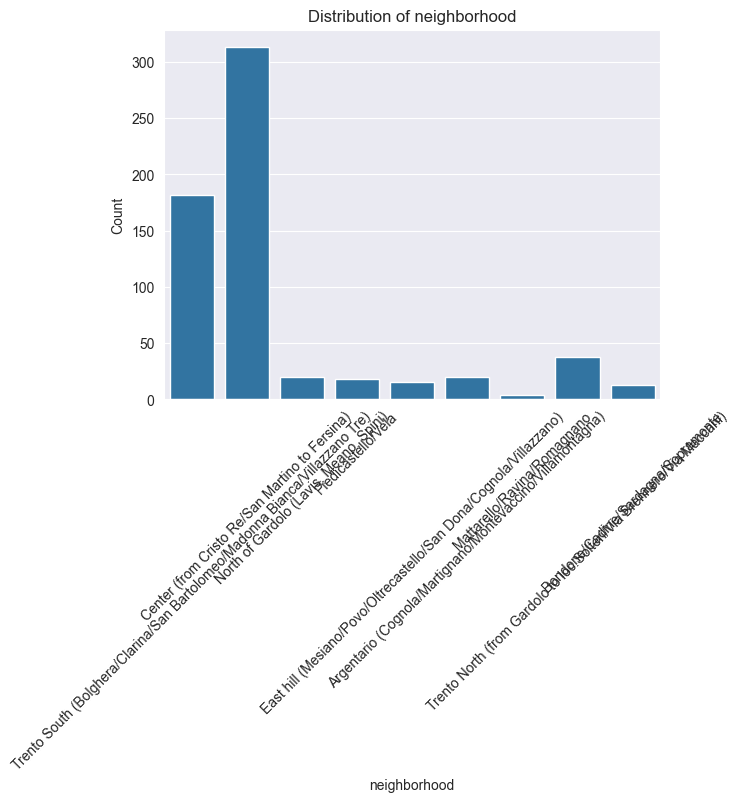

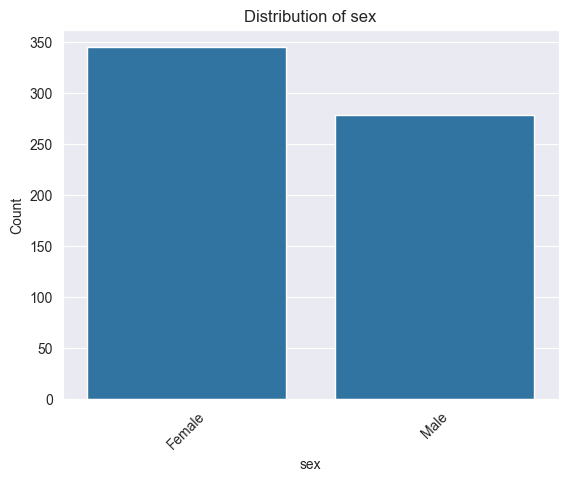

In [6]:
variables = list(dataset.columns)

for var in variables:
    #plt.figure(figsize=(8, 6))
    sns.countplot(x=var, data=dataset, orient="y")
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-labels for better readability
    plt.show()


# MODEL IMPLEMENTATION
To simplify the analyses we'll define a set of function that will be recursively used for each analysis we want to implement.
Ath the end of the script everything is wrapped up in a single function.

## functions related to the analysis of balanced/unbalanced variables

In [7]:
def get_balanced_variables(data, threshold=0.3):
    """
    Function to identify variables with balanced classes (within a certain threshold).

    Args:
    - data: DataFrame containing predictors
    - threshold: Threshold to determine class balance (default: 0.4, can be adjusted)

    Returns:
    - List of variable names with approximately balanced classes
    """
    balanced_vars = []

    for col in data.columns:

        value_counts = data[col].value_counts(normalize=True)
        min_class_prop = value_counts.min()

        if min_class_prop >= threshold and min_class_prop <= (1 - threshold):
            balanced_vars.append(col)

    return balanced_vars

# -------------------------------------------------------------------------------------

def balance_dataset(X, y):
    """
    Function to create a balanced dataset using a combined oversampling and undersampling technique.

    Args:
    - X: Feature data (DataFrame or array-like)
    - y: Target variable (Series or array-like)

    Returns:
    - X_resampled: Balanced feature data
    - y_resampled: Balanced target variable
    """

    # Define the combined sampling pipeline
    combined_sampler = make_pipeline(SMOTE(random_state=42), TomekLinks())

    # Apply the combined sampling technique
    X_resampled, y_resampled = combined_sampler.fit_resample(X, y)

    return X_resampled, y_resampled



## functions related to the splitting process of training and test set

In [8]:
def split_dataset(predictors, y):
    '''
    Function to manually split the dataset into training and test sets

    Args:
    - predictors: DataFrame containing predictors
    - y: Pd.Series of the variable to predict

    Returns:
    - X_train, X_test, y_train, y_test with the assurance they don't overlap
    '''
    # create a single dataframe
    data = pd.concat([predictors, y], axis=1)

    # shuffle indices
    indices = np.random.permutation(data.index)

    # calculate the split point
    split = int(len(indices) * 0.8)  # we decide to use 80-20 split

    # split the indices
    train_indices = indices[:split]
    test_indices = indices[split:]

    # create the training and test sets
    X_train = predictors.loc[train_indices]
    X_test = predictors.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]

    # check for overlapping samples in the split
    train_samples_manual = set(train_indices)
    test_samples_manual = set(test_indices)

    overlapping_samples_manual = train_samples_manual.intersection(test_samples_manual)

    if overlapping_samples_manual:
        print("Error! There are some overlapping samples")

    else:
        #print("No overlapping samples found between the manually split training and test sets.")
        return X_train, X_test, y_train, y_test


## functions related to the implementation of logistic regression model

In [9]:
# building the model
def compute_model(X_train, y_train, X_test, y_test):
    '''
    Function to compute the logistic regression model
    We use a GridSearch to find the best parameters for each model to avoid overfitting

    Args:
    - X_train: training test ot the predictors
    - y_train: training test ot the target variable
    - X: DataFrame containing predictors
    - y: Pd.Series of the variable to predict

    Returns:
    - best_params: the paramters of the model with the best results
    - evaluation_metrics: a dict of the evaluation metrics for the model with the best results
    '''

    # compute the model
    model = linear_model.LogisticRegression()

    # hyperparameters grid for tuning
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 200, 300, 500, 700, 1000]}

    # we perform the GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # define the best hyperparameters
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Compute various evaluation metrics
    evaluation_metrics = {}

    evaluation_metrics['accuracy'] = accuracy_score(y_test, y_pred)
    evaluation_metrics['precision'] = precision_score(y_test, y_pred, average='weighted')
    evaluation_metrics['recall'] = recall_score(y_test, y_pred, average='weighted')
    evaluation_metrics['F1-score'] = f1_score(y_test, y_pred, average='weighted')
    evaluation_metrics['ROC AUC'] = roc_auc_score(y_test, y_pred)  # Only for binary classification

    return best_params, evaluation_metrics

## functions related to feature selection process
we use bivariate analysis to identify the most relevant predictors in the analysis and improve the regression model

In [10]:
def cr_calculate(preds, y):
    '''
    Function to compute the Cramer's V test between the predictors and the target variable

    Args:
    - preds: DataFrame of the predictors
    - y: Pd.Series of the variable to predict

    Returns:
    - res: dictionary with relative Cramer's V value and p-value for each association
    '''
    var_preds = list(preds.columns)
    res = []

    for var in var_preds:
        current_res ={}
        current_res['x var'] = var
        current_res['y var'] = y.name

        # compute the contingency table and the chi2 test
        current_data = np.array(pd.crosstab(preds[var], y))
        chitest = chi2_contingency(current_data)

        # compute the Cramer's V test
        n = np.sum(current_data)
        minDim = min(current_data.shape)-1
        v_value = np.sqrt((chitest[0]/n) / minDim)

        current_res['v-value'] = v_value
        current_res['p-value'] = chitest[1]

        if chitest[1] <= 0.01:
            current_res['p-value sig'] = "***"

        elif chitest[1] > 0.01 and chitest[1] <= 0.05:
            current_res['p-value sig'] = "**"

        elif chitest[1] > 0.05 and chitest[1] <= 0.1:
            current_res['p-value sig'] = "*"

        elif chitest[1] > 0.1:
            current_res['p-value sig'] = "no significant"

        res.append(current_res)

    return res

# -------------------------------------------------------------------------

def preds_selection(bivariate_vals):
    '''
    Function to parse all the bivariate analyses and select the most important predicotrs

    Args:
    - bivariate_vals: lis of dictionaries explaining the relation between each predictor and the target variable

    Returns:
    - new_predictors: list of the most important predicotrs
    '''
    new_predictors = []

    # we select the most important predictors for the y variable
    for el in bivariate_vals:
        # drop the not significant or not very significant cases
        if (el['p-value sig'] == '***') or (el['p-value sig'] == '**'):

            # drop the cases with a weak relation
            if el['v-value'] >= 0.6:
                new_predictors.append(el['x var'])

    return new_predictors

## function to compute everything together

In [11]:
def compute_all(predictors, target):
    '''
    Function to perform a logistic regression model on the target variable, evaluate it and then improve it.

    Args:
    - predictors: DataFrame of the predictors
    - target: pd.Series of the target variable

    Returns:
    - model_implementation: a dict with all the information considering the model computed
    '''

    model_features = {}
    model_features['target'] = target.name

    # we balance the dataset to have target variable with balanced classes
    balance_X, balance_y = balance_dataset(predictors, target)

    # find the variables among the predictors with balanced classes
    selected_predictors = get_balanced_variables(balance_X)

    X_train, X_test, y_train, y_test = split_dataset(balance_X[selected_predictors], balance_y)

    initial_params, initial_eval_metrics = compute_model(X_train, y_train, X_test, y_test)
    # -------------------------------------------

    # apply a feature selection on the subset of predictors using bivariate analysis
    bivariate_vals = cr_calculate(balance_X[selected_predictors], balance_y)
    new_predictors = preds_selection(bivariate_vals)

    if len(new_predictors) != 0:
        # ----------------------------------------------------------
        # if we find a subset of predictors that influence the target, we refit the model
        new_X_train, new_X_test, new_y_train, new_y_test = split_dataset(balance_X[selected_predictors], balance_y)
        new_params, new_eval_metrics = compute_model(new_X_train, new_y_train, new_X_test, new_y_test)

        # we keep the initial model
        if initial_eval_metrics['accuracy'] > new_eval_metrics['accuracy']:
            model_features['parameters'] = initial_params
            model_features['evaluation metrics'] = initial_eval_metrics
            model_features['predictors'] = selected_predictors

        # we keep the model with a subset of predictors
        elif initial_eval_metrics['accuracy'] <= new_eval_metrics['accuracy']:
            model_features['parameters'] = new_params
            model_features['evaluation metrics'] = new_eval_metrics
            model_features['predictors'] = new_predictors
    else:
        # we keep the initial model
        model_features['parameters'] = initial_params
        model_features['evaluation metrics'] = initial_eval_metrics
        model_features['predictors'] = selected_predictors

    return model_features

# apply these function to the current dataset

In [12]:
# one-hot label encoding: we transform all complete dataset into dummy variables
encoded_dataset = pd.get_dummies(dataset, dtype=int)
encoded_dataset.head()

,type of activity_Gymnastics and fitness,type of activity_Indoor activities,type of activity_Outdoor activities,type of activity_Walking,type of activity_Walking and Running,location_indoor,location_outdoor,company_alone,company_company,degree_BSc,...,neighborhood_Bondone/Cadine/Sardagna/Sopramonte,neighborhood_Center (from Cristo Re/San Martino to Fersina),neighborhood_East hill (Mesiano/Povo/Oltrecastello/San Dona/Cognola/Villazzano),neighborhood_Mattarello/Ravina/Romagnano,"neighborhood_North of Gardolo (Lavis, Meano, Spini)",neighborhood_Piedicastello/Vela,neighborhood_Trento North (from Gardolo to loc.Solteri/Via Brennero/Via Maccani),neighborhood_Trento South (Bolghera/Clarina/San Bartolomeo/Madonna Bianca/Villazzano Tre),sex_Female,sex_Male
0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [13]:
# we predict the probability of doing the different sport activities
possible_targets = ['type of activity_Gymnastics and fitness',
                    'type of activity_Indoor activities',
                    'type of activity_Outdoor activities',
                    'type of activity_Walking',
                    'type of activity_Walking and Running']

In [14]:
res = [] # we store here all the results

for el in possible_targets:
    encoded_predictors = encoded_dataset.drop(el, axis=1) # create the X dataset
    encoded_target = encoded_dataset[el] # create the y dataset

    current_res = compute_all(encoded_predictors, encoded_target) # compute the model
    res.append(current_res) # store the results

In [16]:
for el in res:
    print(el)
    print("\n---------------------------------------------")

{'target': 'type of activity_Gymnastics and fitness', 'parameters': {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}, 'evaluation metrics': {'accuracy': 0.9476744186046512, 'precision': 0.9492603284840434, 'recall': 0.9476744186046512, 'F1-score': 0.9476655747447662, 'ROC AUC': 0.9483225108225108}, 'predictors': ['type of activity_Walking', 'location_indoor', 'location_outdoor', 'company_alone', 'company_company', 'degree_BSc', 'degree_MSc', 'neighborhood_Center (from Cristo Re/San Martino to Fersina)', 'sex_Female', 'sex_Male']}

---------------------------------------------
{'target': 'type of activity_Indoor activities', 'parameters': {'C': 10.0, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}, 'evaluation metrics': {'accuracy': 0.8589743589743589, 'precision': 0.8878802357063227, 'recall': 0.8589743589743589, 'F1-score': 0.8540264256565893, 'ROC AUC': 0.8443396226415094}, 'predictors': ['location_indoor', 'location_